In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import tempfile
import gzip
import pylhe
import math
from auxPlots import  xSecTest, getInfoSMS
from aux import getLHEevents, getDistributions, getInfo, getInfoSummary

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [2]:
def AddInfoToDistributions(distributions, model, process, mPsiT, mSDM, info, nlo = False):
    """Adds the model name, process and mass parameters to the final dictionary"""
    converter_dict = {'TopEFT': 'EFT', 'UV_BSM': '1-loop UV', 'sm':'SM',
                      'qq2ttbar_gs4_ydm2': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4_ydm2': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4_ydm2': r'$p p \to t \bar{t}$ ', 'qq2ttbar_gs6': r'$q q \to t \bar{t}$', 'gg2ttbar_gs6': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs6': r'$p p \to t \bar{t}$', 'qq2ttbar_gs4': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4': r'$p p \to t \bar{t}$', 'gs4': r'$g_s^4$', 'gs6': r'$g_s^6$', 'ydm2': r'$y_{DM}^2$'}
    
    #Add new keys with the new information
    distributions['model'] = converter_dict[model]
    distributions['process'] = info['process']
    distributions['mass_params'] = (mPsiT,mSDM)
    distributions['ydm'] = info['(mSDM,mPsiT,mT,yDM)'][-1]

    if nlo == True:
        distributions['weights'] = distributions['nevents']*distributions['weights']

    #Correcting the weights when doing bias generation
    if abs((distributions['xsec (pb)']-info['xsec (pb)'])/info['xsec (pb)']) > 0.01 and nlo == True:
        distributions['weights'] = (info['xsec (pb)']/distributions['xsec (pb)']) * distributions['weights']
        distributions['xsec (pb)'] = info['xsec (pb)']
    

    distributions['cp_order'] = [r'$g_s^4$', r'$y_{DM}^2$']
    
    return distributions

In [3]:
def AddInfoToDistributionsSMS(distributions, model, process, mST, mChi, info, nlo = False):
    """Adds the model name, process and mass parameters to the final dictionary"""
    converter_dict = {'TopEFT': 'EFT', 'UV_BSM': '1-loop UV', 'sm':'SM',
                      'SMS EFT': 'SMS EFT', 'SMS 1-Loop': '1-loop SMS',
                      'qq2ttbar_gs4_ydm2': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4_ydm2': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4_ydm2': r'$p p \to t \bar{t}$ ', 'qq2ttbar_gs6': r'$q q \to t \bar{t}$', 'gg2ttbar_gs6': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs6': r'$p p \to t \bar{t}$', 'qq2ttbar_gs4': r'$q q \to t \bar{t}$', 'gg2ttbar_gs4': r'$g g \to t \bar{t}$',
                      'pp2ttbar_gs4': r'$p p \to t \bar{t}$', 'gs4': r'$g_s^4$', 'gs6': r'$g_s^6$', 'ydm2': r'$y_{DM}^2$'}
    
    #Add new keys with the new information
    distributions['model'] = converter_dict[model]
    distributions['process'] = info['process']
    distributions['mass_params'] = (mST,mChi)
    distributions['ydm'] = info['(mST,mChi,mT,yDM)'][-1]

    if nlo == True:
        distributions['weights'] = distributions['nevents']*distributions['weights']

    #Correcting the weights when doing bias generation
    if abs((distributions['xsec (pb)']-info['xsec (pb)'])/info['xsec (pb)']) > 0.01 and nlo == True:
        distributions['weights'] = (info['xsec (pb)']/distributions['xsec (pb)']) * distributions['weights']
        distributions['xsec (pb)'] = info['xsec (pb)']
    

    distributions['cp_order'] = [r'$g_s^4$', r'$y_{DM}^2$']
    
    return distributions

In [4]:
def selectColor(model, process):
    if model == 'EFT':
        return sns.color_palette('Paired')[0]
    elif model == '1-loop UV':
        return sns.color_palette('Paired')[1]
    elif model == 'SMS EFT':
        return sns.color_palette('Paired')[2]
    else:
        return sns.color_palette('Paired')[3]

In [5]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/*/Events/spinFlip*/*events.lhe.gz'))
print(files)

['/home/vinicius/EFT_ToyModel/processFolders/TopEFT/gg2ttbar_gs4_ydm2/Events/spinFlip_500_400/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/TopEFT/gg2ttbar_gs4_ydm2/Events/spinFlip_1000_900/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/TopEFT/qq2ttbar_gs4_ydm2/Events/spinFlip_500_400/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/TopEFT/qq2ttbar_gs4_ydm2/Events/spinFlip_1000_900/unweighted_events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/gg2ttbar_gs4_ydm2/Events/spinFlip_500_400/events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/gg2ttbar_gs4_ydm2/Events/spinFlip_1000_900/events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/qq2ttbar_gs4_ydm2/Events/spinFlip_500_400/events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/UV_BSM/qq2ttbar_gs4_ydm2/Events/spinFlip_1000_900/events.lhe.gz', '/home/vinicius/EFT_ToyModel/processFolders/SMS_EFT/gg2ttbar_gs4_ydm2/Events/sp

In [6]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/*/Events/spinFlip*/*events.lhe.gz'))
data = []
info = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if 'TopEFT' in f:
        info.append(getInfo(f, nlo = False))
        d = AddInfoToDistributions(d,'TopEFT',info[i]['process'], info[i]['(mSDM,mPsiT,mT,yDM)'][1], 
                                       info[i]['(mSDM,mPsiT,mT,yDM)'][0], info[i])
    if 'UV_BSM' in f:
        info.append(getInfo(f, nlo = True))
        d = AddInfoToDistributions(d,'UV_BSM',info[i]['process'], info[i]['(mSDM,mPsiT,mT,yDM)'][1], 
                                       info[i]['(mSDM,mPsiT,mT,yDM)'][0], info[i], nlo = True)
    if 'SMS_EFT' in f:
        info.append(getInfoSMS(f, nlo = False))
        d = AddInfoToDistributionsSMS(d,'SMS EFT',info[i]['process'], info[i]['(mST,mChi,mT,yDM)'][0], 
                                       info[i]['(mST,mChi,mT,yDM)'][1], info[i], nlo = False)
    if 'SMS_1_loop' in f:
        info.append(getInfoSMS(f, nlo = True))
        d = AddInfoToDistributionsSMS(d,'SMS 1-Loop',info[i]['process'], info[i]['(mST,mChi,mT,yDM)'][0], 
                                       info[i]['(mST,mChi,mT,yDM)'][1], info[i], nlo = True)
  

    data.append(d)

data = sorted(data, key=lambda d: d['mass_params'][0])

In [7]:
print(data[8])

{'mTT': array([1924.56506881,  816.9812474 ,  895.90652725, ...,  670.24933754,
        485.5275552 ,  400.5727201 ], shape=(100000,)), 'pT1': array([622.47895948, 267.45015092, 143.84605855, ..., 258.44474552,
       107.71122283, 100.35628753], shape=(100000,)), 'pT2': array([622.47895948, 267.45015092, 143.84605855, ..., 258.44474552,
       107.71122283, 100.35628753], shape=(100000,)), 'deltaPhi': array([3.14159265, 3.14159265, 3.14159265, ..., 3.14159265, 3.14159265,
       3.14159265], shape=(100000,)), 'weights': array([1.4581911e-06, 8.0919920e-06, 6.7290585e-06, ..., 1.2022839e-05,
       2.2911414e-05, 3.3660213e-05], shape=(100000,)), 'pT': array([622.47895948, 267.45015092, 143.84605855, ..., 258.44474552,
       107.71122283, 100.35628753], shape=(100000,)), 'nevents': 100000, 'xsec (pb)': 1.8697456, 'xSecErr (pb)': 0.00086462857, 'model': 'EFT', 'process': '$g g \\to t \\bar{t}$', 'mass_params': (1000.0, 900.0), 'ydm': 10.0, 'cp_order': ['$g_s^4$', '$y_{DM}^2$']}


In [8]:
xSecTest(data)

EFT $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
EFT $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop UV $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop UV $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
SMS EFT $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
SMS EFT $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop SMS $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop SMS $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
EFT $g g \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
EFT $q q \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
1-loop UV $g g \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
1-loop UV $q q \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
SMS EFT $g g \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
SMS EFT $q q \to t \bar{t}$  mPsiT: 1000.0, mSDM: 900.0 Result: Passed
1-loop SMS $g g 

In [9]:
for d in data:
    print(d['model'], d['mass_params'])

EFT (500.0, 400.0)
EFT (500.0, 400.0)
1-loop UV (500.0, 400.0)
1-loop UV (500.0, 400.0)
SMS EFT (500.0, 400.0)
SMS EFT (500.0, 400.0)
1-loop SMS (500.0, 400.0)
1-loop SMS (500.0, 400.0)
EFT (1000.0, 900.0)
EFT (1000.0, 900.0)
1-loop UV (1000.0, 900.0)
1-loop UV (1000.0, 900.0)
SMS EFT (1000.0, 900.0)
SMS EFT (1000.0, 900.0)
1-loop SMS (1000.0, 900.0)
1-loop SMS (1000.0, 900.0)


# Invariant mass $qq\to t\bar{t}$

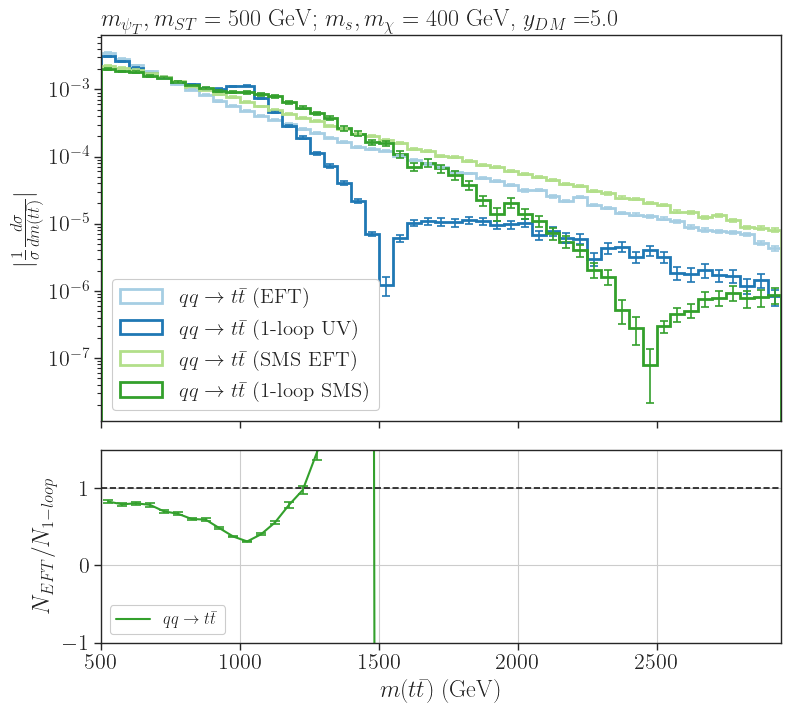

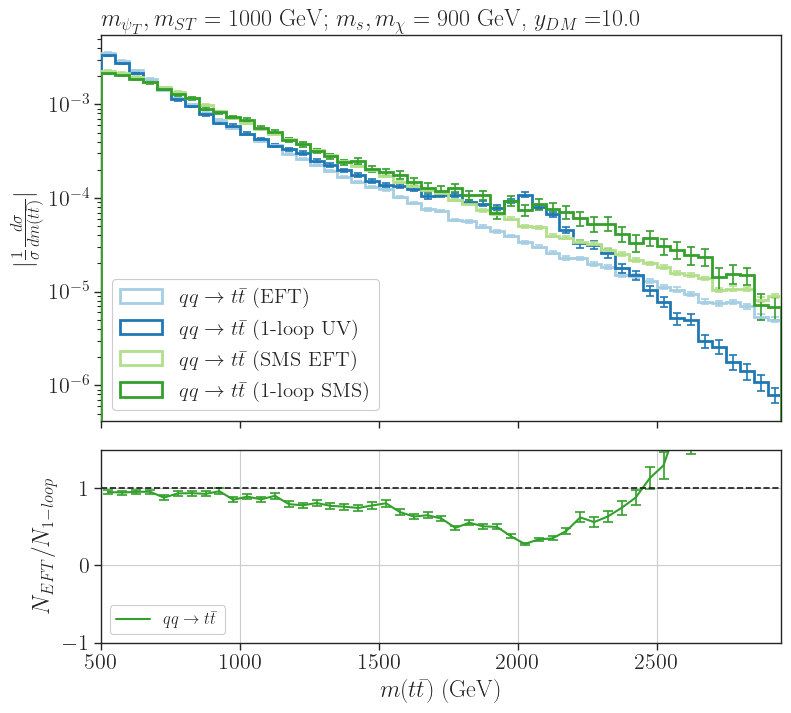

In [10]:
# Generating the BSM histograms and plotting them


#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data), 8):
    #Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #Variables used to store hist info
    #BSM masses
    mPsiT,mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    #Defining the binning according to the BSM masses
    #if mPsiT < 800.0:
     #   bins = np.arange(400.,1550.,35.)
    #elif mPsiT <= 1250:
     #   bins = np.arange(500.,2000.,45.)
    #else:
     #   bins = np.arange(700.,3300.,75.)
    bins = np.arange(500.,3000.,50.)
    #Loop over the processes and models


    
    
    #variables to store info
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    hErr_norm = []
    c = []
    hists_norm = []
    
    for j,d in enumerate(selected):
        if r'$g g \to t \bar{t}$' in d['process']:
            labels.append('0')
            c.append('0')
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            pmodels.append(r'%s (%s)' %(process,model))
            #Cs and weights test
            #if model == '1-loop UV':
             #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
            #else:
             #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
            label = pmodels[-1]
            labels.append(label)
            c.append(selectColor(model,process))
            h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
            hists.append(h)
            #Compute MC error
            hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)    
            histsErr.append(hErr)
            #Plotting the BSM hists
            aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step', density = True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
            hists_norm.append(aux[0])
            
            #Plotting the errors
            x = (bins[:-1]+bins[1:])/2.0
            y = aux[0]
            #Propagating the error since we are dealing with normalized histograms
            yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
            hErr_norm.append(yErr)
            axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
           
        
    

    #Ratio plot
    # Separating the EFT and the 1-loop UV results
    hLoop = hists[1]
    hLoop_Err = histsErr[1]
    hEFT = hists[0]
    hEFT_Err = histsErr[0]
    #Computing the ratio EFT/1-loop UV
    labels_r = [r'$q q \to t \bar{t}$']
    ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
    ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
    # Remove zero values
    nonzero = np.where((np.sign(ratio) != 0))
    x = (bins[:-1]+bins[1:])/2.0
    y = ratio
    label = labels_r[0]
        #Ratio plots
    axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
    axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
    #Main plot configs
    axarr[0].legend(framealpha=1.0,loc='lower left',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
    #Subplot configs
    axarr[1].set_ylim(-1,1.5)
    #axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
    #axarr[1].set_yscale('log')
    axarr[1].grid()
    axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
    axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

EFT
1-loop UV
SMS EFT
1-loop SMS
EFT
1-loop UV
SMS EFT
1-loop SMS


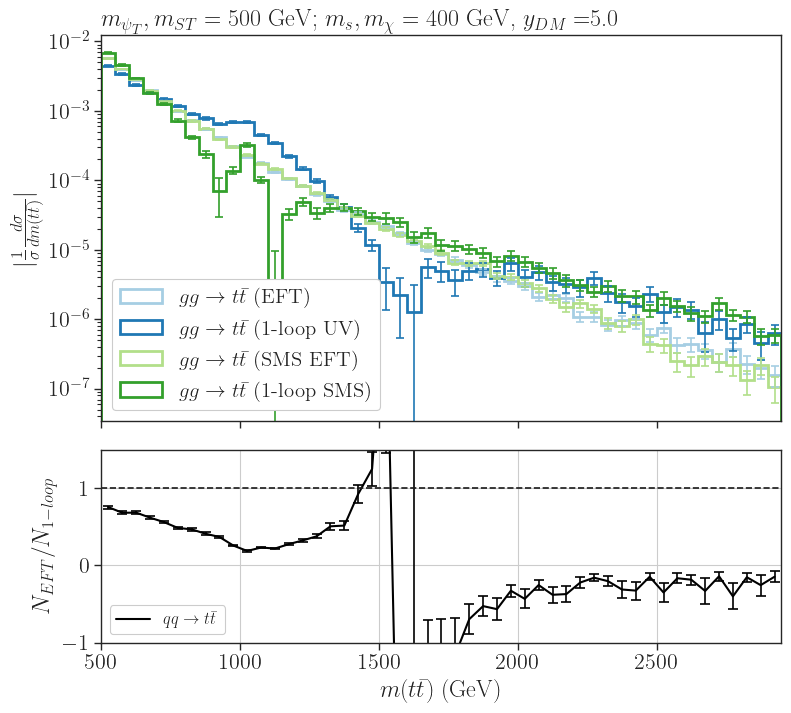

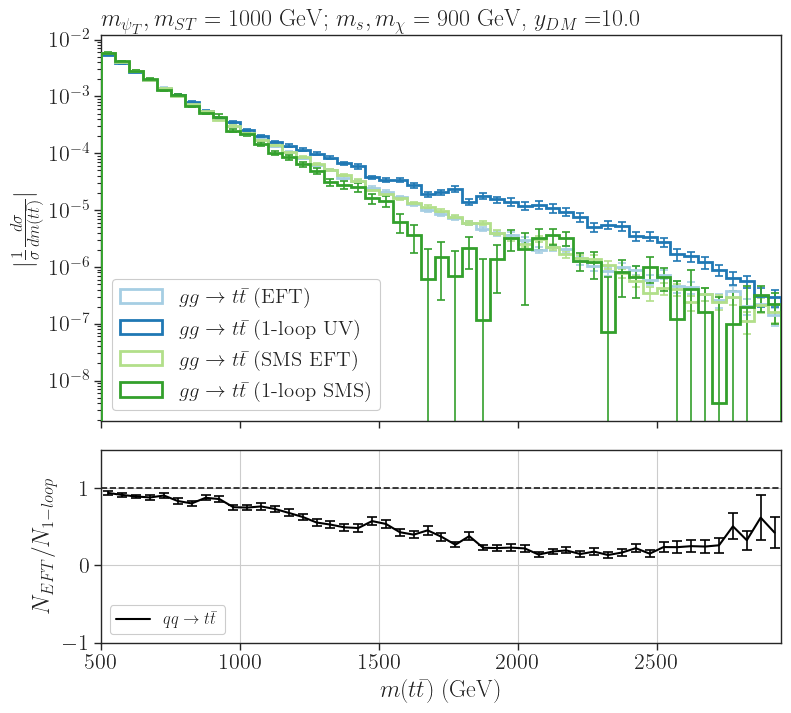

In [11]:
# Generating the BSM histograms and plotting them


#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data), 8):
    #Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #Variables used to store hist info
    #BSM masses
    mPsiT,mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    #Defining the binning according to the BSM masses
    #if mPsiT < 800.0:
     #   bins = np.arange(400.,1550.,35.)
    #elif mPsiT <= 1250:
     #   bins = np.arange(500.,2000.,45.)
    #else:
     #   bins = np.arange(700.,3300.,75.)
    bins = np.arange(500.,3000.,50.)
    #Loop over the processes and models


    
    
    #variables to store info
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    hErr_norm = []
    c = []
    hists_norm = []
    
    for j,d in enumerate(selected):
        if r'$q q \to t \bar{t}$' in d['process']:
            labels.append('0')
            c.append('0')
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            pmodels.append(r'%s (%s)' %(process,model))
            #Cs and weights test
            #if model == '1-loop UV':
             #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
            #else:
             #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
            label = pmodels[-1]
            labels.append(label)
            c.append(selectColor(model,process))
            h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
            hists.append(h)
            #Compute MC error
            hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)    
            histsErr.append(hErr)
            #Plotting the BSM hists
            aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
            hists_norm.append(aux[0])
            
            #Plotting the errors
            x = (bins[:-1]+bins[1:])/2.0
            y = aux[0]
            #Propagating the error since we are dealing with normalized histograms
            yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
            hErr_norm.append(yErr)
            axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
           
        
    

    #Ratio plot
    # Separating the EFT and the 1-loop UV results
    hLoop = hists[1]
    hLoop_Err = histsErr[1]
    hEFT = hists[0]
    hEFT_Err = histsErr[0]
    #Computing the ratio EFT/1-loop UV
    labels_r = [r'$q q \to t \bar{t}$']
    ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
    ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
    # Remove zero values
    nonzero = np.where((np.sign(ratio) != 0))
    x = (bins[:-1]+bins[1:])/2.0
    y = ratio
    label = labels_r[0]
        #Ratio plots
    axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
    axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
    #Main plot configs
    axarr[0].legend(framealpha=1.0,loc='lower left',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
    #Subplot configs
    axarr[1].set_ylim(-1,1.5)
    #axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
    #axarr[1].set_yscale('log')
    axarr[1].grid()
    axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
    axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

In [12]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/qq2ttbar_gs4_ydm2/Events/biasTest1/*events.lhe.gz'))
data_s1 = []
info = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        info.append(getInfo(f, nlo = False))
        d = AddInfoToDistributions(d,'TopEFT','qq2ttbar_gs4_ydm2', 5000., 4750., info[0])
    else:
        info.append(getInfo(f, nlo = True))
        d = AddInfoToDistributions(d,'UV_BSM','qq2ttbar_gs4_ydm2', 5000., 4750., info[1], nlo= True)

    data_s1.append(d)



In [13]:
xSecTest(data_s1)

EFT $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed
1-loop UV $q q \to t \bar{t}$  mPsiT: 5000.0, mSDM: 4750.0 Result: Passed


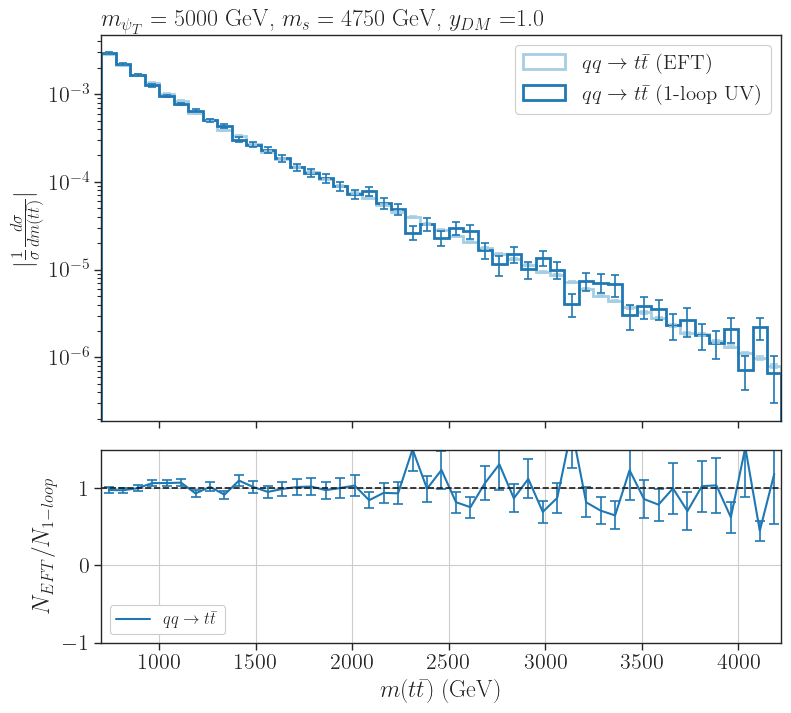

In [14]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s1

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hists_norm = []
hErr_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(700.,4300.,75.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#   label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                         # color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         #linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        #Cs and weights test
        #if model == '1-loop UV':
        #   print('UV:', d['nevents']*sum(d['weights']), d['xsec (pb)'])
        #else:
        #   print('EFT:', sum(d['weights']), d['xsec (pb)'])
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()


# $p_T$ $qq\to t\bar{t}$

In [15]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hErr_norm = []
hists_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#    label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                       #   color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                        # linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
    #Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()

NameError: name 'data_s' is not defined

# Without bias
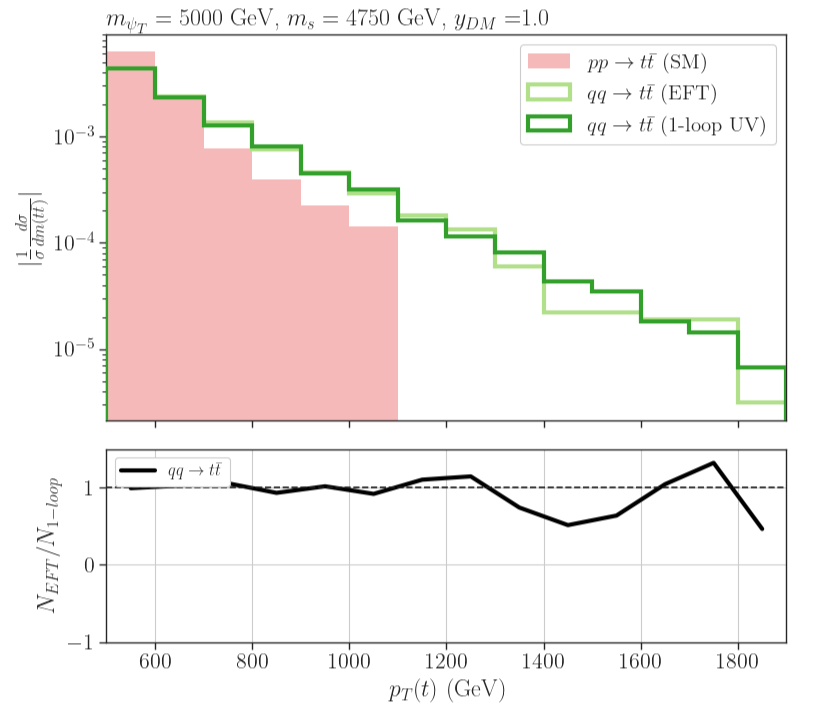


In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s1

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
hErr_norm = []
hists_norm = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
#labels_sm = []
#pmodels = []
#hists_sm = []
#histsErr_sm = []

#for d in data_sm:
#    process = d['process']
#    model = d['model']
#    weights = d['weights']
#    pmodels.append(r'%s (%s)' %(process,model))
#    label = pmodels[-1]
#    labels_sm.append(label)
#    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
#    hists_sm.append(h)
    #Compute MC error
#    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
#    hErr = np.sqrt(hErr)    
#    histsErr_sm.append(hErr)
#Plotting the SM hist
#axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                       #   color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                        # linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$g g \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=2,fill=False,zorder=i,linestyle='solid')
        hists_norm.append(aux[0])
            
        #Plotting the errors
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #Propagating the error since we are dealing with normalized histograms
        yErr = abs(y)*np.sqrt((np.array(hErr)/np.array(h))**2 + sum(np.power(hErr,2))/(sum(h)**2))
        hErr_norm.append(yErr)
        axarr[0].errorbar(x,aux[0], yerr = yErr,
                          color=c[j], fmt = 'none', capsize = 3, capthick = 1.2, barsabove = True)
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists_norm[1]
hLoop_Err = hErr_norm[1]
hEFT = hists_norm[0]
hEFT_Err = hErr_norm[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$q q \to t \bar{t}$']
ratio = np.divide(hEFT , hLoop, out=np.zeros_like(hLoop),where=hLoop != 0)
ratio_Err = abs(ratio)*np.sqrt((np.array(hEFT_Err)/np.array(hEFT))**2 + (np.array(hLoop_Err)/np.array(hLoop))**2)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
        #Ratio plots
axarr[1].plot(x,y,linewidth=1.5,linestyle='solid',alpha=1,
                              label=label,c=c[j])
axarr[1].errorbar(x,y, yerr = ratio_Err,
                          color=c[j], fmt = 'o', ms = 0, capsize = 3.5, capthick = 1.2 )
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='lower left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
    
plt.show()

# $qq\to t\bar{t}$

In [ ]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/*/gg2ttbar_gs4_ydm2/Events/run_Stest/*events.lhe.gz'))
data_s = []
for i,f in enumerate(files):
    d = getDistributions(f)
    if i == 0:
        d = AddInfoToDistributions(d,'TopEFT','gg2ttbar_gs4_ydm2', 2000., 1900.)
    else:
        d = AddInfoToDistributions(d,'UV_BSM','gg2ttbar_gs4_ydm2', 2000., 1900.)
    data_s.append(d)


In [ ]:
print(files)

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(400.,2000.,75.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(0,1.2)
axarr[1].set_yticks(np.arange(0,1.2,0.1))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    
plt.show()

In [ ]:
#Generating the BSM histograms and plotting them
# Coupling value
yDM = 1.0

    
selected = data_s

#Defining the space for the two plots 
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

#Variables used to store hist info
labels = []
pmodels = []
hists = []
histsErr = []
c = []
mPsiT,mSDM = selected[0]['mass_params']
#Defining the binning according to the BSM masses

bins = np.arange(500.,2000.,100.)

#Loop over the processes and models

#SM plot
labels_sm = []
pmodels = []
hists_sm = []
histsErr_sm = []

for d in data_sm:
    process = d['process']
    model = d['model']
    weights = d['weights']
    pmodels.append(r'%s (%s)' %(process,model))
    label = pmodels[-1]
    labels_sm.append(label)
    h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
    hists_sm.append(h)
    #Compute MC error
    hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
    hErr = np.sqrt(hErr)    
    histsErr_sm.append(hErr)
#Plotting the SM hist
axarr[0].hist(bins[:-1],weights=np.abs(hists_sm[2]),label=labels_sm[2],bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')  

    
for j,d in enumerate(selected):
    if r'$q q \to t \bar{t}$' in d['process']:
        labels.append('0')
        c.append('0')
        continue
    else:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels.append(label)
        c.append(selectColor(model,process))
        h,_ = np.histogram(d['pT'],bins=bins,weights=d['weights'])
        hists.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['pT'],bins=bins,weights=(d['weights'])**2)
        hErr = np.sqrt(hErr)    
        histsErr.append(hErr)
        #Plotting the BSM hists
        axarr[0].hist(bins[:-1],weights=abs(h),label=labels[j],bins=bins,
                              color=c[j],alpha=1.0,histtype='step',density=True,
                             linewidth=3,fill=False,zorder=i,linestyle='solid')
    

#Ratio plot
# Separating the EFT and the 1-loop UV results
hLoop = hists[1]
hEFT = hists[0]
#Computing the ratio EFT/1-loop UV
labels_r = [r'$g g \to t \bar{t}$']
    
ratio = np.divide(hEFT/sum(hEFT) , hLoop/sum(hLoop), out=np.zeros_like(hLoop),where=hLoop != 0)
# Remove zero values
nonzero = np.where((np.sign(ratio) != 0))
x = (bins[:-1]+bins[1:])/2.0
y = ratio
label = labels_r[0]
#Ratio plots
axarr[1].plot(x,y,linewidth=3.0,linestyle='solid',alpha=1,
                              label=label,c=c[0])
        
#Main plot configs
axarr[0].legend(framealpha=1.0,loc='upper right',fontsize=15)
axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
axarr[0].set_yscale('log')
axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
axarr[0].set_xlim(bins.min(),bins.max())
axarr[1].set_ylabel(r'$N_{EFT}/N_{1-loop}$')
    
#Subplot configs
axarr[1].set_ylim(-1,1.5)
#axarr[1].set_yticks(np.arange(-0.01,0.05,0.01))
#axarr[1].set_yscale('log')
axarr[1].grid()
axarr[1].axhline(y=1, color='k', linestyle='--')
axarr[1].legend(loc='upper left',fontsize=12,framealpha=1.0,ncol=2)
axarr[1].set_xlabel(r'$pT(t)$ (GeV)')
    
plt.show()